### Score and compare
This notebook numbers and scores the 450,000 sequence test sets using AntPack / SAM, then loads
scores assigned by other tools and compares all of the results.

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from Bio import SeqIO
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, auc
from sklearn.metrics import average_precision_score
from antpack import SequenceScoringTool

if "notebooks" in os.getcwd():
    os.chdir(os.path.join("..", ".."))
    current_dir = os.getcwd()

#Normally we adjust scores based on the median score seen in the original training set --
#this ensures both heavy and light chains are on the same scale. For the evaluations in
#this file, however, we want to see raw scores. Also, normally we don't want to use
#SAM as a classifier, but for some evaluations here we do.
score_tool = SequenceScoringTool(adjusted_scores = False, offer_classifier_option=True)

os.chdir(current_dir)

Loading scores from comparators is a little complicated, since the comparators output their results
in different formats. BioPhi, for example, generates excel files, and AbNativ generates
separate files for kappa and lambda chains. First, load BioPhi and AbNativ.

In [2]:
if "results_and_resources" not in os.getcwd():
    os.chdir(os.path.join(current_dir, "results_and_resources", "biophi_results"))

scoring = { chain:{ key:{"scores":[], "species":[], "labels":[]} for key in ["Biophi", "AbNativ", "Hu-mAb"]} for
           chain in ["heavy", "light"] }

for chain in ["abybank_heavy", "abybank_light"]:
    scoring[chain] = { key:{"scores":[], "species":[], "labels":[]} for key in ["AbNativ", "Hu-mAb"]}

for chain in ["light", "heavy"]:
    species_list = ["_".join(fh.split(".xlsx")[0].split("_")[2:]) for fh in os.listdir() if f"{chain}_biophi_" in fh]

    for species in species_list:
        species_code = 0
        if species == "human":
            species_code = 1
        bxl = pd.read_excel(f"{chain}_biophi_{species}.xlsx")
        scoring[chain]["Biophi"]["scores"] += bxl["OASis Identity"].tolist()
        scoring[chain]["Biophi"]["species"] += [species for i in range(bxl.shape[0])]
        scoring[chain]["Biophi"]["labels"] += [species_code for i in range(bxl.shape[0])]

        if chain == "heavy":
            bxl = pd.read_csv(f"../abnativ_results/heavy_abnativ_{species}.txt")
            scoring["heavy"]["AbNativ"]["scores"] += bxl.iloc[:,0].tolist()
            scoring["heavy"]["AbNativ"]["species"] += [species for i in range(bxl.shape[0])]
            scoring["heavy"]["AbNativ"]["labels"] += [species_code for i in range(bxl.shape[0])]
        else:
            for chain_subtype in ["kappa", "lambda"]:
                fname = f"light_abnativ_{species}_{chain_subtype}.txt"
                if fname not in os.listdir("../abnativ_results"):
                    continue
                bxl = pd.read_csv(os.path.join("..", "abnativ_results", fname))
                scoring["light"]["AbNativ"]["scores"] += bxl.iloc[:,0].tolist()
                scoring["light"]["AbNativ"]["species"] += [species for i in range(bxl.shape[0])]
                scoring["light"]["AbNativ"]["labels"] += [species_code for i in range(bxl.shape[0])]

Next, we're going to number and score all of the test sequences using AntPack / SAM. This should take a few
minutes. Note that we score the test set both in classification mode and in scoring mode.

In [3]:
import time

if "results_and_resources" not in os.getcwd():
    os.chdir(os.path.join(current_dir, "results_and_resources"))


for chain in ["heavy", "light"]:
    st = time.time()
    scoring[chain]["SAM"] = {"scores":[],"species":[], "labels":[]}
    os.chdir(os.path.join(current_dir, "train_test_data_immunogenicity_0.0.1", f"{chain}_chain", "test_sample_sequences"))
    flist = [f for f in os.listdir() if f.endswith("fasta")]

    for fname in flist:
        print(fname)
        with open(fname, "r") as fhandle:
            seqs = [str(s.seq) for s in SeqIO.parse(fhandle, "fasta")]

        species = fname.split(".fasta")[0].split("test_subsample_")[1]
        scoring[chain]["SAM"]["scores"] += score_tool.batch_score_seqs(seqs, mode="score").tolist()
        scoring[chain]["SAM"]["species"] += [species for s in seqs]
        if species == "human":
            scoring[chain]["SAM"]["labels"] += np.ones((len(seqs))).tolist()
        else:
            scoring[chain]["SAM"]["labels"] += np.zeros((len(seqs))).tolist()

    print(f"Time elapsed: {time.time() - st}")
    
os.chdir(os.path.join(current_dir, "train_test_data_immunogenicity_0.0.1", "abybank_compiled_data", f"{chain}_abybank"))
scoring[f"abybank_{chain}"]["SAM"] = {"scores":[],"species":[], "labels":[]}
flist = [f for f in os.listdir() if f.endswith(".fa")]
        
for fname in flist:
    print(fname)
    with open(fname, "r") as fhandle:
        seqs = [str(s.seq) for s in SeqIO.parse(fhandle, "fasta")]

    species = fname.split("_seqs.fa")[0].split(f"{chain}_")[1]
    scoring[f"abybank_{chain}"]["SAM"]["scores"] += score_tool.batch_score_seqs(seqs).tolist()
    scoring[f"abybank_{chain}"]["SAM"]["species"] += [species for s in seqs]
    if species == "human":
        scoring[f"abybank_{chain}"]["SAM"]["labels"] += np.ones((len(seqs))).tolist()
    else:
        scoring[f"abybank_{chain}"]["SAM"]["labels"] += np.zeros((len(seqs))).tolist()

for chain in ["heavy", "light"]:
    scoring[chain]["SAM_classifier"] = {"scores":[],"species":[], "labels":[]}
    os.chdir(os.path.join(current_dir, "train_test_data_immunogenicity_0.0.1", f"{chain}_chain", "test_sample_sequences"))
    flist = [f for f in os.listdir() if f.endswith("fasta")]

    for fname in flist:
        print(fname)
        with open(fname, "r") as fhandle:
            seqs = [str(s.seq) for s in SeqIO.parse(fhandle, "fasta")]

        species = fname.split(".fasta")[0].split("test_subsample_")[1]
        scoring[chain]["SAM_classifier"]["scores"] += score_tool.batch_score_seqs(seqs, mode="classifier").tolist()
        scoring[chain]["SAM_classifier"]["species"] += [species for s in seqs]
        if species == "human":
            scoring[chain]["SAM_classifier"]["labels"] += np.ones((len(seqs))).tolist()
        else:
            scoring[chain]["SAM_classifier"]["labels"] += np.zeros((len(seqs))).tolist()

test_subsample_mouse_balbc.fasta
test_subsample_rat.fasta
test_subsample_mouse_c576.fasta
test_subsample_human.fasta
test_subsample_rhesus.fasta
test_subsample_camel.fasta
test_subsample_rabbit.fasta
Time elapsed: 67.29349565505981
test_subsample_mouse_balbc.fasta
test_subsample_human.fasta
test_subsample_rhesus.fasta
Time elapsed: 26.94150185585022
light_human_seqs.fa
light_guinea_seqs.fa
light_rhesus_seqs.fa
light_rabbit_seqs.fa
light_horse_seqs.fa
test_subsample_mouse_balbc.fasta
test_subsample_rat.fasta
test_subsample_mouse_c576.fasta
test_subsample_human.fasta
test_subsample_rhesus.fasta
test_subsample_camel.fasta
test_subsample_rabbit.fasta
test_subsample_mouse_balbc.fasta
test_subsample_human.fasta
test_subsample_rhesus.fasta


Now we continue to load other scores: IGLM, Progen, AbLSTM, AntiBERTy (log-likelihood not classifier --
the AntiBERTy classifier is scored in a separate notebook), Hu-mAb.

In [4]:
os.chdir(os.path.join(current_dir, "results_and_resources"))

for tool in ["iglm", "progen", "ablstm", "antiberty"]:
    for chain in ["heavy", "light"]:
        bxl = pd.read_csv(f"{chain}_{tool}_scores.txt", header=None)

        #Strangely, some tools (e.g. ablstm) assign lower scores to human sequences.
        #We therefore have to label them in reverse or their ROC-AUC will be VERY poor.
        if tool != "iglm":
            labels = ((bxl.iloc[:,0] != "human") * 1).tolist()
        else:
            labels = (bxl.iloc[:,0] == "human") * 1
        scoring[chain][tool] = {"scores":bxl.iloc[:,-1].astype(float).tolist(),
                                     "species":bxl.iloc[:,0].tolist(), "labels":labels}


os.chdir("humab_results")

for chain in ["heavy", "light"]:
    flist = [f for f in os.listdir() if f.endswith(f"{chain}.txt") and "HUMAB" in f]

    for fname in flist:
        species = "_".join(fname.split("HUMAB")[0].split("_")[2:])
        species_code = 0
        if species == "human":
            species_code = 1

        with open(fname, "r") as fhandle:
            _ = fhandle.readline()
            for line in fhandle:
                score = np.array([float(x) for x in line.strip().split(",")]).max()
                scoring[chain]["Hu-mAb"]["scores"].append(score)
                scoring[chain]["Hu-mAb"]["species"].append(species)
                scoring[chain]["Hu-mAb"]["labels"].append(species_code)

In [5]:
os.chdir(os.path.join(current_dir, "results_and_resources", "humab_abybank"))

for chain in ["heavy", "light"]:
    species_list = [fh.split("_HUMAB.txt")[0].split("_")[1] for fh in os.listdir() if f"{chain}_" in fh]

    for species in species_list:
        species_code = 0
        if species == "human":
            species_code = 1

        with open(f"{chain}_{species}_HUMAB.txt", "r") as fhandle:
            _ = fhandle.readline()
            for line in fhandle:
                score = np.array([float(x) for x in line.strip().split(",")]).max()
                scoring[f"abybank_{chain}"]["Hu-mAb"]["scores"].append(score)
                scoring[f"abybank_{chain}"]["Hu-mAb"]["species"].append(species)
                scoring[f"abybank_{chain}"]["Hu-mAb"]["labels"].append(species_code)

os.chdir(os.path.join(current_dir, "results_and_resources"))

Plot the score distributions...

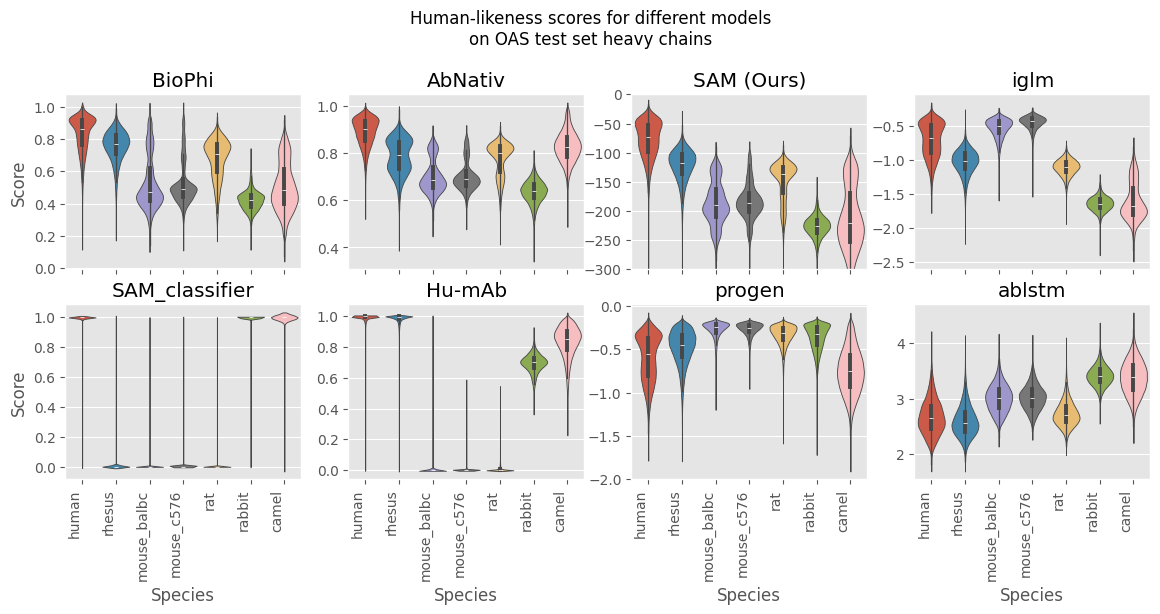

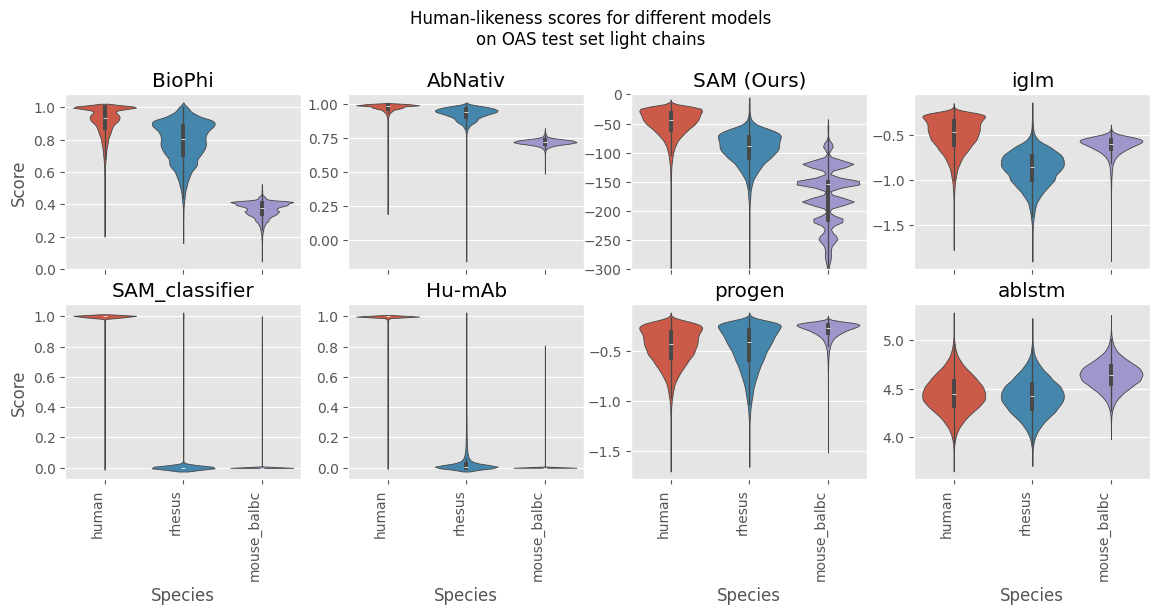

In [6]:
plt.style.use("ggplot")
preferred_order = {"heavy":["human", "rhesus", "mouse_balbc", "mouse_c576", "rat", "rabbit", "camel"],
                      "light":["human", "rhesus", "mouse_balbc"]}

tool_list = ['Biophi', 'AbNativ', 'SAM', 'iglm', 'SAM_classifier', 'Hu-mAb', 'progen', 'ablstm']

for chain in ["heavy", "light"]:
    fig, ((ax1,ax2,ax3,ax4), (ax5,ax6,ax7,ax8)) = plt.subplots(2,4, figsize=(14,5), sharex=True)
    axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]
    chain_scores = scoring[chain]
    
    for tool, ax in zip(tool_list, axes):
        sns.violinplot(y=chain_scores[tool]["scores"], x=chain_scores[tool]["species"],
                    hue=chain_scores[tool]["species"], ax=ax, order=preferred_order[chain],
                   hue_order=preferred_order[chain])
    
    
        for label in ax.get_xticklabels():
            label.set_rotation(90)
            label.set_ha('right')
        if tool == "SAM":
            ax.set_title(f"{tool} (Ours)")
            #Some sequences receive extremely low scores from SAM so we clip the plot
            #for better visibility.
            ax.set_ylim(-300,0)
        elif tool == "Biophi":
            ax.set_title("BioPhi")
        else:
            ax.set_title(f"{tool}")

    ax5.set_xlabel("Species")
    ax6.set_xlabel("Species")
    ax7.set_xlabel("Species")
    ax8.set_xlabel("Species")
    
    ax1.set_ylabel("Score")
    ax5.set_ylabel("Score")
    plt.suptitle(f"Human-likeness scores for different models\non OAS test set {chain} chains", y=1.05)
    plt.show()

Next, calculate AUC-ROC and AUC-PRC scores. We bootstrap here to estimate a confidence interval
and figure out what performance would look like on the full test set. Note that as a result
this part is a little slow and may take 5 minutes or so.

In [10]:
combined_results = {"tool":[], "chain":[], "AUC-ROC":[], "AUC-ROC_LCB":[], "AUC-ROC_UCB":[],
                    "AUC-PRC":[], "AUC-PRC_LCB":[], "AUC-PRC_UCB":[]}

tools = ['Biophi', 'AbNativ', 'Hu-mAb', 'SAM', 'SAM_classifier', 'iglm', 'progen',
                 'ablstm', 'antiberty']

for chain in ["heavy", "light"]:
    print(f"AUC-ROC results, chain {chain}")

    for tool in tools:
        auc_values = []
        gt_scores = np.array(scoring[chain][tool]["labels"])
        input_scores = np.array(scoring[chain][tool]["scores"])
        rng = np.random.default_rng(123)

        for i in range(1000):
            idx = rng.choice(gt_scores.shape[0], gt_scores.shape[0])
            auc_values.append(roc_auc_score(gt_scores[idx], input_scores[idx]))

        auc_values = np.sort(np.array(auc_values))
        combined_results["tool"].append(tool)
        combined_results["chain"].append(chain)
        combined_results["AUC-ROC"].append(roc_auc_score(gt_scores, input_scores))
        combined_results["AUC-ROC_LCB"].append(auc_values[25])
        combined_results["AUC-ROC_UCB"].append(auc_values[975])

        print(f"{tool}:\t{combined_results['AUC-ROC'][-1]}\tLCB: {auc_values[25]}\tUCB:{auc_values[975]}")

    print("\n")

print("\n\n\n")

for chain in ["heavy", "light"]:
    print(f"AUC-PRC results, chain {chain}")

    for tool in tools:
        auc_values = []
        gt_scores = np.array(scoring[chain][tool]["labels"])
        if tool in ["ablstm", "antiberty", "progen"]:
            gt_scores -= 1
            gt_scores[gt_scores<0] = 1
        input_scores = np.array(scoring[chain][tool]["scores"])

        rng = np.random.default_rng(123)

        for i in range(1000):
            idx = rng.choice(gt_scores.shape[0], gt_scores.shape[0])
            auc_values.append(average_precision_score(gt_scores[idx], input_scores[idx]))

        
        score = average_precision_score(gt_scores, input_scores)
        
        auc_values = np.sort(np.array(auc_values))
        combined_results["AUC-PRC"].append(score)
        combined_results["AUC-PRC_LCB"].append(auc_values[25])
        combined_results["AUC-PRC_UCB"].append(auc_values[975])

        print(f"{tool}:\t{score}\tLCB: {auc_values[25]}\tUCB:{auc_values[975]}")

    print("\n")

AUC-ROC results, chain heavy
Biophi:	0.8839155753950789	LCB: 0.8822669547529327	UCB:0.8853805508937493
AbNativ:	0.899871208892475	LCB: 0.8984669190571299	UCB:0.9013374521226211
Hu-mAb:	0.9427076680536107	LCB: 0.941897278384934	UCB:0.9434704142721276
SAM:	0.9536932079215844	LCB: 0.9527289881123044	UCB:0.9545693511270544
SAM_classifier:	0.8798989815963192	LCB: 0.8788482395396573	UCB:0.8810209448641397
iglm:	0.7967970897779556	LCB: 0.7951756837166443	UCB:0.7983003307570061
progen:	0.6846479511502301	LCB: 0.6824092495883223	UCB:0.6871080663646004
ablstm:	0.7439903879975995	LCB: 0.7420354316442226	UCB:0.7461975072354781
antiberty:	0.5425644590918184	LCB: 0.5402235153103361	UCB:0.5449405778722132


AUC-ROC results, chain light
Biophi:	0.9082337499835877	LCB: 0.9068764205821187	UCB:0.9096355979197805
AbNativ:	0.9328404228216787	LCB: 0.9316506239307413	UCB:0.9340715976234882
Hu-mAb:	0.9986480579443301	LCB: 0.998462228441792	UCB:0.9988124046130802
SAM:	0.9482599997943796	LCB: 0.9471659208312617

Finally, let's look at the performance of another classifier (Hu-mAb) on light chains for more diverse
species. Classifiers can achieve better accuracy on species that are present in their training set but
are less robust and tend to exhibit erratic behavior on species not present in their training set. In
this case, for example, we see that Hu-mAb assigns very low scores (close to 0) for mouse light chains (see above),
but assigns scores > 0.8 -- very similar to what it assigns to human and identical to what it assigns to
humanized sequences -- to light chains from horses, guinea pigs and rabbits.
That's not because these species are more human, that's because they're not
present in Hu-mAb's training set. Scoring using a generative model (e.g. SAM, AbNativ) 
without first converting it to a classifier doesn't show this behavior. (Generative models
can be converted to a classifier by building a generative model for each species, and as we
show above with SAM-classifier this exhibits behavior very similar to a classification model
like Hu-mAb).

AUC-ROC: Hu-mAb:	0.97228	LCB: 0.9659215506431731	UCB:0.977982829527452
AUC-PRC: Hu-mAb:	0.9611753421549888	LCB: 0.9505089073466906	UCB:0.9703796844905043
AUC-ROC: SAM:	0.9959577777777778	LCB: 0.9933156120360774	UCB:0.9982087328496172
AUC-PRC: SAM:	0.9972078755637687	LCB: 0.9956330661293763	UCB:0.9985712678889009


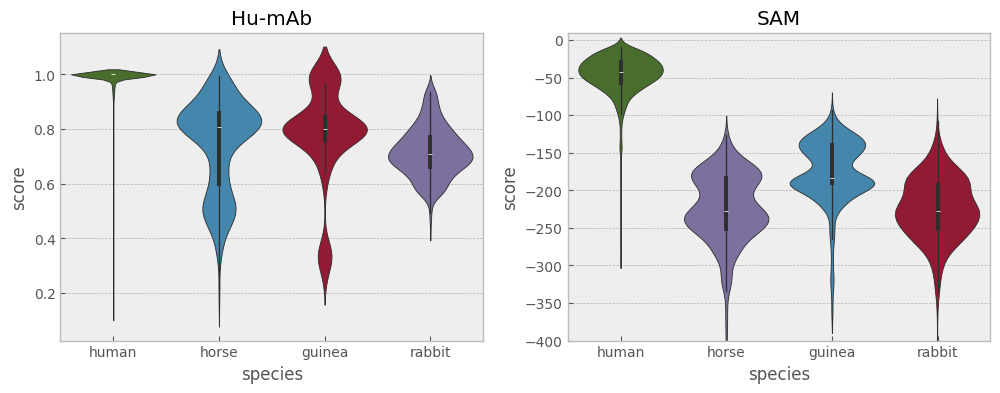

In [11]:
plt.style.use('bmh')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))

species_order = ["human", "horse", "guinea", "rabbit"]



for chain in ["abybank_light"]:
    for ax, tool in zip([ax1, ax2], ['Hu-mAb', 'SAM']):
        rng = np.random.default_rng(123)
        df = pd.DataFrame.from_dict(scoring[chain][tool])
        subset = df[df['species'].isin(['rabbit', 'horse', 'guinea'])]
        #There are more human than nonhuman, so we randomly select a subset of the human
        #of equal size to the number of nonhuman.
        human_subset = df[df['species']=="human"]
        idx = rng.permutation(human_subset.shape[0])
        human_subset = human_subset.iloc[idx[:1500],:]
        subset = pd.concat([subset, human_subset], axis=0)

        sns.violinplot(x="species", y="scores", hue="species", data=subset, ax=ax, order=species_order)
        ax.set_ylabel("score")
        ax.set_title(tool)
        if tool == "SAM":
            ax.set_ylim(-400,10)

        gt_scores = subset['labels'].values
        input_scores = subset['scores'].values
        auc_values, prc_values = [], []

        for i in range(1000):
            idx = rng.choice(gt_scores.shape[0], gt_scores.shape[0])
            auc_values.append(roc_auc_score(gt_scores[idx], input_scores[idx]))
            prc_values.append(average_precision_score(gt_scores[idx], input_scores[idx]))

        auc_values = np.sort(np.array(auc_values))
        prc_values = np.sort(np.array(prc_values))
        print(f"AUC-ROC: {tool}:\t{roc_auc_score(gt_scores, input_scores)}\tLCB: {auc_values[25]}\tUCB:{auc_values[975]}")
        print(f"AUC-PRC: {tool}:\t{average_precision_score(gt_scores, input_scores)}\tLCB: {prc_values[25]}\tUCB:{prc_values[975]}")

In [12]:
combined_df = pd.DataFrame.from_dict(combined_results)
combined_df

,tool,chain,AUC-ROC,AUC-ROC_LCB,AUC-ROC_UCB,AUC-PRC,AUC-PRC_LCB,AUC-PRC_UCB
0,Biophi,heavy,0.883916,0.882267,0.885381,0.683661,0.679306,0.687762
1,AbNativ,heavy,0.899871,0.898467,0.901337,0.652120,0.647258,0.657486
2,Hu-mAb,heavy,0.942708,0.941897,0.943470,0.663927,0.660157,0.667882
3,SAM,heavy,0.953693,0.952729,0.954569,0.870674,0.868354,0.872841
4,SAM_classifier,heavy,0.879899,0.878848,0.881021,0.470832,0.467528,0.474159
5,iglm,heavy,0.796797,0.795176,0.798300,0.335073,0.331863,0.338464
6,progen,heavy,0.684648,0.682409,0.687108,0.114123,0.113065,0.115157
7,ablstm,heavy,0.743990,0.742035,0.746198,0.105650,0.104760,0.106544
8,antiberty,heavy,0.542564,0.540224,0.544941,0.140796,0.139511,0.142172
9,Biophi,light,0.908234,0.906876,0.909636,0.827909,0.824997,0.831014
